# ANN 돌리기


In [8]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 데이터

In [9]:
# years = '2016-01-2021-05-31'
years = '2002-2021-05'

df = pd.read_csv('./data/' + years + '_all.csv')
df['일시'] = df['Unnamed: 0']
df = df.drop(columns='Unnamed: 0')
df['일시'] = pd.to_datetime(df['일시'])
df.set_index('일시',inplace=True)
data = df
display(df.head(3))
display(df.tail(3))
print(df.shape)
result = []     # metric 담을 lst

,평균 수온(°C)
일시,
2002-01-01,12.9000
2002-01-02,12.2000
2002-01-03,11.9000


,평균 수온(°C)
일시,
2021-05-29,17.6000
2021-05-30,17.9000
2021-05-31,18.2000


(7091, 1)


In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1
    # df 365개
    # trn_df 365-20 = 345개
    # 345 - 15 - 5 + 1 = 326개

  def __getitem__(self, i):
    idx = (i + self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx + self.forecast_size]
    
    return look_back, forecast
  
class Net(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out)
    self.activation = activation

  def forward(self, x):
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    return x # scaled 시 2가지 케이스

def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

def mse(y_pred, y_true):
  return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

def rmse(y_pred, y_true):
  return np.sqrt(mse(y_pred, y_true))

def r_squared(y_pred, y_true):
  return r2_score(y_true, y_pred)

# 실험

## 1년/5년치 데이터에 넣을 ord_lst

In [4]:
# pred_size = 15, 30, 60, 90
# lookback = 5, 15, 30, 90
# forecast = 1, 5, 15

# 총 72 개

ord_lst = [[15, 5, 1, 400, 0.0001], [15, 5, 1, 700, 0.0001], [15, 5, 1, 1000, 0.0001]]


# ord_lst = [[15, 5, 1, 400, 0.0001], [15, 5, 1, 700, 0.0001], [15, 5, 1, 1000, 0.0001], 
#            [15, 5, 5, 400, 0.0001], [15, 5, 5, 700, 0.0001], [15, 5, 5, 1000, 0.0001], 
#            [15, 5, 15, 400, 0.0001], [15, 5, 15, 700, 0.0001], [15, 5, 15, 1000, 0.0001], 
           
#            [15, 15, 1, 400, 0.0001], [15, 15, 1, 700, 0.0001], [15, 15, 1, 1000, 0.0001], 
#            [15, 15, 5, 400, 0.0001], [15, 15, 5, 700, 0.0001], [15, 15, 5, 1000, 0.0001], 
#            [15, 15, 15, 400, 0.0001], [15, 15, 15, 700, 0.0001], [15, 15, 15, 1000, 0.0001], 
           
#            [15, 30, 1, 400, 0.0001], [15, 30, 1, 700, 0.0001], [15, 30, 1, 1000, 0.0001], 
#            [15, 30, 5, 400, 0.0001], [15, 30, 5, 700, 0.0001], [15, 30, 5, 1000, 0.0001], 
#            [15, 30, 15, 400, 0.0001], [15, 30, 15, 700, 0.0001], [15, 30, 15, 1000, 0.0001], 
           
#            [15, 90, 1, 400, 0.0001], [15, 90, 1, 700, 0.0001], [15, 90, 1, 1000, 0.0001], 
#            [15, 90, 5, 400, 0.0001], [15, 90, 5, 700, 0.0001], [15, 90, 5, 1000, 0.0001], 
#            [15, 90, 15, 400, 0.0001], [15, 90, 15, 700, 0.0001], [15, 90, 15, 1000, 0.0001], 
    


#            [30, 5, 1, 400, 0.0001], [30, 5, 1, 700, 0.0001], [30, 5, 1, 1000, 0.0001], 
#            [30, 5, 5, 400, 0.0001], [30, 5, 5, 700, 0.0001], [30, 5, 5, 1000, 0.0001], 
#            [30, 5, 15, 400, 0.0001], [30, 5, 15, 700, 0.0001], [30, 5, 15, 1000, 0.0001], 
           
#            [30, 15, 1, 400, 0.0001], [30, 15, 1, 700, 0.0001], [30, 15, 1, 1000, 0.0001], 
#            [30, 15, 5, 400, 0.0001], [30, 15, 5, 700, 0.0001], [30, 15, 5, 1000, 0.0001], 
#            [30, 15, 15, 400, 0.0001], [30, 15, 15, 700, 0.0001], [30, 15, 15, 1000, 0.0001], 
           
#            [30, 30, 1, 400, 0.0001], [30, 30, 1, 700, 0.0001], [30, 30, 1, 1000, 0.0001], 
#            [30, 30, 5, 400, 0.0001], [30, 30, 5, 700, 0.0001], [30, 30, 5, 1000, 0.0001], 
#            [30, 30, 15, 400, 0.0001], [30, 30, 15, 700, 0.0001], [30, 30, 15, 1000, 0.0001], 
           
#            [30, 90, 1, 400, 0.0001], [30, 90, 1, 700, 0.0001], [30, 90, 1, 1000, 0.0001], 
#            [30, 90, 5, 400, 0.0001], [30, 90, 5, 700, 0.0001], [30, 90, 5, 1000, 0.0001], 
#            [30, 90, 15, 400, 0.0001], [30, 90, 15, 700, 0.0001], [30, 90, 15, 1000, 0.0001],
      


#            [60, 5, 1, 400, 0.0001], [60, 5, 1, 700, 0.0001], [60, 5, 1, 1000, 0.0001], 
#            [60, 5, 5, 400, 0.0001], [60, 5, 5, 700, 0.0001], [60, 5, 5, 1000, 0.0001], 
#            [60, 5, 15, 400, 0.0001], [60, 5, 15, 700, 0.0001], [60, 5, 15, 1000, 0.0001], 
           
#            [60, 15, 1, 400, 0.0001], [60, 15, 1, 700, 0.0001], [60, 15, 1, 1000, 0.0001], 
#            [60, 15, 5, 400, 0.0001], [60, 15, 5, 700, 0.0001], [60, 15, 5, 1000, 0.0001], 
#            [60, 15, 15, 400, 0.0001], [60, 15, 15, 700, 0.0001], [60, 15, 15, 1000, 0.0001], 
           
#            [60, 30, 1, 400, 0.0001], [60, 30, 1, 700, 0.0001], [60, 30, 1, 1000, 0.0001], 
#            [60, 30, 5, 400, 0.0001], [60, 30, 5, 700, 0.0001], [60, 30, 5, 1000, 0.0001], 
#            [60, 30, 15, 400, 0.0001], [60, 30, 15, 700, 0.0001], [60, 30, 15, 1000, 0.0001], 
           
#            [60, 90, 1, 400, 0.0001], [60, 90, 1, 700, 0.0001], [60, 90, 1, 1000, 0.0001], 
#            [60, 90, 5, 400, 0.0001], [60, 90, 5, 700, 0.0001], [60, 90, 5, 1000, 0.0001], 
#            [60, 90, 15, 400, 0.0001], [60, 90, 15, 700, 0.0001], [60, 90, 15, 1000, 0.0001], 
      

    
#            [90, 5, 1, 400, 0.0001], [90, 5, 1, 700, 0.0001], [90, 5, 1, 1000, 0.0001], 
#            [90, 5, 5, 400, 0.0001], [90, 5, 5, 700, 0.0001], [90, 5, 5, 1000, 0.0001], 
#            [90, 5, 15, 400, 0.0001], [90, 5, 15, 700, 0.0001], [90, 5, 15, 1000, 0.0001], 
           
#            [90, 15, 1, 400, 0.0001], [90, 15, 1, 700, 0.0001], [90, 15, 1, 1000, 0.0001], 
#            [90, 15, 5, 400, 0.0001], [90, 15, 5, 700, 0.0001], [90, 15, 5, 1000, 0.0001], 
#            [90, 15, 15, 400, 0.0001], [90, 15, 15, 700, 0.0001], [90, 15, 15, 1000, 0.0001], 
           
#            [90, 30, 1, 400, 0.0001], [90, 30, 1, 700, 0.0001], [90, 30, 1, 1000, 0.0001], 
#            [90, 30, 5, 400, 0.0001], [90, 30, 5, 700, 0.0001], [90, 30, 5, 1000, 0.0001], 
#            [90, 30, 15, 400, 0.0001], [90, 30, 15, 700, 0.0001],[90, 30, 15, 1000, 0.0001], 
           
#            [90, 90, 1, 400, 0.0001], [90, 90, 1, 700, 0.0001], [90, 90, 1, 1000, 0.0001], 
#            [90, 90, 5, 400, 0.0001], [90, 90, 5, 700, 0.0001], [90, 90, 5, 1000, 0.0001], 
#            [90, 90, 15, 400, 0.0001], [90, 90, 15, 700, 0.0001], [90, 90, 15, 1000, 0.0001]]

# 시작

# 저장하며 실험

90 5 1 1000 0.0001


100%|██████████| 1000/1000 [12:51<00:00,  1.30it/s, trn_loss=0.275, tst_loss=0.276, tst_mape=2.68, tst_mae=0.39, tst_rmse=0.525]


torch.Size([90, 1])
(90,)
(90,)


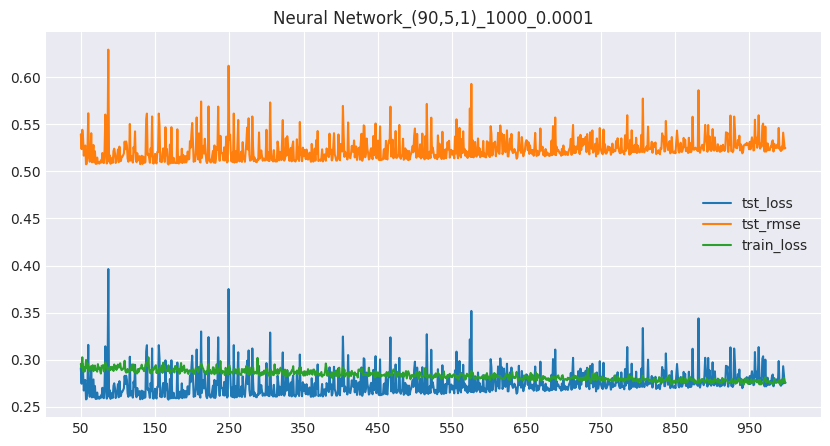

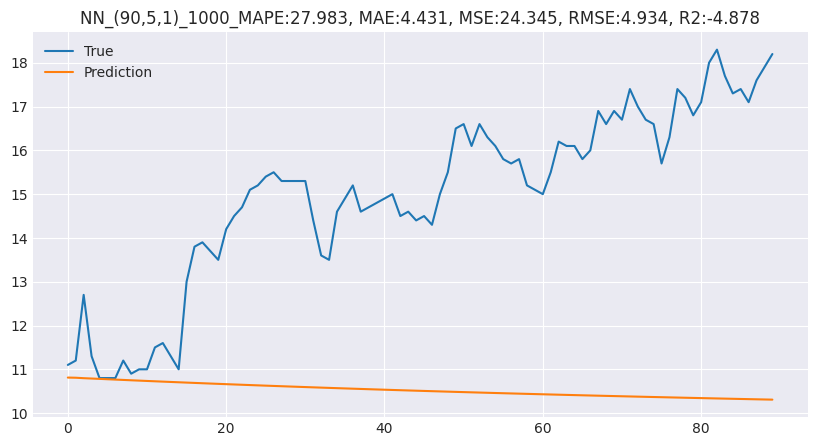

In [5]:
for pred_size, lookback_size, forecast_size, epoch, lr in ord_lst:
	print(pred_size, lookback_size, forecast_size, epoch, lr)
	scaler = MinMaxScaler()
	trn_scaled = scaler.fit_transform(data[:-pred_size].to_numpy(dtype=np.float32)).flatten()
	tst_scaled = scaler.transform(data[-pred_size-lookback_size:].to_numpy(dtype=np.float32)).flatten()

	trn_df = data[:-pred_size].to_numpy(dtype=np.float32).flatten()
	tst_df = data[-pred_size - lookback_size:].to_numpy(dtype=np.float32).flatten()
	tst_y = tst_df[-pred_size:]

	### 스케일 안한 케이스
	trn_Ods = TimeSeriesDataset(trn_df, lookback_size, forecast_size)
	tst_Ods = TimeSeriesDataset(tst_df, lookback_size, forecast_size)

	trn_Odl = DataLoader(trn_Ods, batch_size=32, shuffle=True)
	tst_Odl = DataLoader(tst_Ods, batch_size=pred_size, shuffle=False)

	#### 스케일 한 케이스
	trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
	# tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

	trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
	# tst_dl = DataLoader(tst_ds, batch_size=pred_size, shuffle=False)

	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	net = Net(lookback_size, forecast_size, 512)
	net.to(device)
	optim = torch.optim.AdamW(net.parameters(), lr=lr)
	pbar = trange(epoch)
	losses = []
	trn_losses = []
	tst_rmse_losses = []

	for i in pbar:
		net.train()
		trn_loss = .0

		for x, y in trn_Odl: # 여기 2가지 케이스
			x, y = x.to(device), y.to(device)   # (32,15), (32, 5) in 32줄 (총 326개)
			p = net(x)    # (32, 5)인 predict output
			optim.zero_grad()
			loss = F.mse_loss(p, y)   # pred 와 target 차이
			loss.backward()
			optim.step()
			trn_loss += loss.item() * len(y)
		trn_loss = trn_loss / len(trn_Ods) # 여기 2가지 케이스

		net.eval()
		with torch.inference_mode():
			x, y = next(iter(tst_Odl)) # 여기 2가지 케이스
			x, y = x.to(device), y.to(device)     # x: input(15), y: target(5)
			p = net(x)                            # p: 예측 값(5)
			tst_loss = F.mse_loss(p, y) 
			y = y.cpu()
			p = p.cpu()    
			tst_mape = mape(p,y)
			tst_mae = mae(p,y)
			tst_rmse = rmse(p,y)
			tst_mse = mse(p,y)


		pbar.set_postfix({'trn_loss':trn_loss, 'tst_loss':tst_loss.item(), 'tst_mape':tst_mape.item(), 
												'tst_mae':tst_mae.item(), 'tst_rmse':tst_rmse.item()})
		tst_loss = tst_loss.cpu()  

		losses.append(tst_loss)
		trn_losses.append(trn_loss)
		tst_rmse_losses.append(tst_rmse)

	plot_start = 50     # 1부터 하면 훅 떨어지는거 그리느라 뒷부분이 잘 안보여서 확대한 것
	epochs_to_plot = range(plot_start, epoch)
	plt.figure(figsize=(10, 5))
	plt.title(f"Neural Network_({pred_size},{lookback_size},{forecast_size})_{epoch}_{lr}")
	plt.plot(epochs_to_plot, losses[plot_start:], label='tst_loss')
	plt.plot(epochs_to_plot, tst_rmse_losses[plot_start:], label='tst_rmse')
	plt.plot(epochs_to_plot, trn_losses[plot_start:], label='train_loss')
	plt.xticks(range(plot_start, epoch, 100))
	plt.legend()
	plt.savefig(f'./fig_ANN/ANN_loss_{years}_({pred_size},{lookback_size},{forecast_size})_{epoch}_{lr}.png')
	plt.show


	preds = []
	x, y = trn_Ods[len(trn_Ods)-1]  #마지막의 input(15개), output(5개) 값을 가져옴
	# print(f'x: {x}, y: {y}\n')

	x = torch.tensor(x)
	# print(np.concatenate([x, y]).shape , x.shape, y.shape)

	net.eval()
	for _ in range(int(pred_size/forecast_size)):
		x = np.concatenate([x, y])[-lookback_size:]   # x = 20개[-15:] 즉, 15개

		with torch.inference_mode():    
			y = net(torch.tensor(x).cuda()).cpu()
			# print(f'y: {y}')
		preds.append(y)

	# print(f'\nlen(preds): {len(preds)}\n')  # len(preds) = 4 개 (for문 range만큼)

	preds = np.concatenate(preds)  # 예측 결과값을 하나의 Numpy 배열로 병합
	# print(f'preds: {preds}')    # 4개(5개씩)를 합치므로 4x5 = 20개

	MAPE = mape(preds,tst_y)
	MAE = mae(preds,tst_y)
	MSE = mse(preds,tst_y)
	RMSE = rmse(preds,tst_y)
	R2 = r_squared(preds,tst_y)
	result.append([(pred_size, lookback_size, forecast_size, epoch, lr), MAPE, MAE, MSE, RMSE, R2])

	print(p.shape)
	print(preds.shape)
	print(tst_y.shape)

	# y = y.numpy()
	# y = y.flatten()
	# preds, tst_y

	plt.figure(figsize=(10, 5))
	plt.title(f"NN_({pred_size},{lookback_size},{forecast_size})_{epoch}_MAPE:{MAPE:.3f}, MAE:{MAE:.3f}, MSE:{MSE:.3f}, RMSE:{RMSE:.3f}, R2:{R2:.3f}")
	plt.plot(range(pred_size), tst_y, label="True")
	plt.plot(range(pred_size), preds, label="Prediction")
	plt.legend()
	plt.savefig(f'./fig_ANN/ANN_{years}_({pred_size},{lookback_size},{forecast_size})_{epoch}_{lr}_hidden1.png')
	plt.show()

# 결과 데이터프레임 생성

In [7]:
pd.set_option('float_format', '{:.4f}'.format)
result_df = pd.DataFrame(result, columns=['order', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])
result_df.set_index('order', inplace=True)
# result_df.to_csv(f'./result/ANN_result_{years}_hidden1.csv')
result_df.to_csv(f'./result/ANN_result_{years}_hidden1_3.csv')

result_df

,MAPE,MAE,MSE,RMSE,R2
order,,,,,
"(90, 5, 1, 1000, 0.0001)",27.9827,4.4309,24.3448,4.9340,-4.8775
